Welcome to this notebook. We'll explore the ATP tennis data records.

The goal is to try to earn money while bidding online. 
If the end model is predicting winning probabilities that are correct, then we can go to a bidding website and compare the «quotes» on the website to the winning probability predicted by the model. And then we bet against any incorrect «quotes». 

Bidders online may underestimate a player's odds, due to a variety of bias in which case we'd bid on him. 

First let's open the CSV, and look a bit a the data

In [10]:
%matplotlib inline
import pandas
import numpy as np
import matplotlib
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

import matplotlib.pyplot as plt
from datetime import datetime
import scipy
from scipy.stats import rv_continuous
import timeout_decorator


In [2]:

tennis_atp_records = pandas.read_csv('ATP.csv', dtype={'tourney_date': str})

tennis_atp_records['tourney_date'] = tennis_atp_records['tourney_date'].apply(lambda datetime_str: datetime.strptime(str(datetime_str), '%Y%m%d'))
#, dtype={"draw_size": numpy.int32}, low_memory=False) 
# i had an error due to various datatypes in the  same column. may it's due to the empty values, NaN. low_memory makes it dynamic
# the problem was actually a incorrect csv. columns headers where included twice,
# the csv was build from copy pasting the text from 2 csv together, without removing the second csv's columns names

/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (9,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
tennis_atp_records[150029:150500][['winner_name', 'loser_name', 'tourney_name', 'tourney_date']]
tennis_atp_records.loc[150044]

tourney_id                       2012-403
tourney_name                Miami Masters
surface                              Hard
draw_size                              96
tourney_level                           M
tourney_date          2012-03-21 00:00:00
match_num                              95
winner_id                          104925
winner_seed                             1
winner_entry                          NaN
winner_name                Novak Djokovic
winner_hand                             R
winner_ht                             188
winner_ioc                            SRB
winner_age                        24.8268
winner_rank                             1
winner_rank_points                  12670
loser_id                           104918
loser_seed                              4
loser_entry                           NaN
loser_name                    Andy Murray
loser_hand                              R
loser_ht                              190
loser_ioc                         

For the Davis Cup, there seems to be as many tournaments as there were country-vs-country matches. Let's see if any other tournament has a 4 player pool size

In [4]:
no_davis = tennis_atp_records[-tennis_atp_records['tourney_name'].apply(lambda X: X.startswith('Davis Cup'))] 
no_davis[no_davis['draw_size'] ==4].loc[:,['tourney_name', 'tourney_date', 'winner_name', 'loser_name']]

,tourney_name,tourney_date,winner_name,loser_name
23469,Pepsi Grand Slam,1976-07-10,Ilie Nastase,Manuel Orantes
23737,WCT Challenge Cup,1976-12-02,Jimmy Connors,Vitas Gerulaitis
23738,WCT Challenge Cup,1976-12-02,Ilie Nastase,Manuel Orantes
23739,WCT Challenge Cup,1976-12-02,Ilie Nastase,Jimmy Connors
29480,Pepsi Grand Slam,1977-07-11,Bjorn Borg,Adriano Panatta
29481,Pepsi Grand Slam,1977-07-11,Jimmy Connors,Manuel Orantes
29482,Pepsi Grand Slam,1977-07-11,Bjorn Borg,Jimmy Connors
34173,Pepsi Grand Slam,1979-02-10,Jimmy Connors,John Mcenroe
34174,Pepsi Grand Slam,1979-02-10,Bjorn Borg,Guillermo Vilas
34175,Pepsi Grand Slam,1979-02-10,Bjorn Borg,Jimmy Connors


It seems like only 16 games where played in «4 players» tournaments outside of the Davis Cup, which are not exactly 4 players tournaments.

I'm interested in knowing how many players are in the ATP circuit, but also, I want to see how many players actually played a lot of matches.

In [5]:
win_counts = tennis_atp_records.groupby('winner_name').count()
win_counts['win_count'] = win_counts['tourney_name']

print(type(win_counts), win_counts.shape, win_counts.columns)
win_counts['win_count'].sort_values()

<class 'pandas.core.frame.DataFrame'> (3509, 49) Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank',
       'winner_rank_points', 'loser_id', 'loser_seed', 'loser_entry',
       'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
       'loser_rank', 'loser_rank_points', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'win_count'],
      dtype='object')


winner_name
A Macdonald                 1
David Egdes                 1
M Borgener                  1
David Felgate               1
M Abid Ali Khan Akbar       1
David Graham                1
David Katcharava            1
Luis Haddock                1
David Livingston            1
Luis Felipe Noriega         1
Luis Delgado                1
Ludi Wijono                 1
Luciano Ramazzini           1
Luciano Cuneo               1
Lucas Gomez                 1
Lucas Catarina              1
David Segal                 1
David Sherwood              1
Louis Wessels               1
David Smith                 1
Lothar Pawlik               1
David Tate                  1
Lorenzo Fargas              1
Lofo Ramiaramanana          1
Lior Mor                    1
Lionel Kemajou              1
M Laimina                   1
Ma Ilahi                    1
Magnus Nilsson              1
Mahader Hassan              1
                         ... 
Carlos Moya               575
Harold Solomon            57

But this is only the wins. Lets look at the loosing names, and sum both.

In [6]:
loose_counts = tennis_atp_records.groupby('loser_name').count()
print(type(loose_counts), loose_counts.shape, loose_counts.columns)
print(loose_counts['tourney_name'].sort_values()['Roger Federer'])
total = (win_counts + loose_counts)['tourney_name'].fillna(-1).sort_values()
total

<class 'pandas.core.frame.DataFrame'> (5534, 48) Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'winner_rank', 'winner_rank_points', 'loser_id', 'loser_seed',
       'loser_entry', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
       'loser_rank', 'loser_rank_points', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced'],
      dtype='object')
248


                            -1.0
L Palman                    -1.0
L Weatherhog                -1.0
Ladislav Svarc              -1.0
Laird Dunlop                -1.0
Laith Azzouni               -1.0
Lance Johnson               -1.0
Lance Lumsden               -1.0
Larbi Rharnit               -1.0
Larry Collins               -1.0
Larry Davidson              -1.0
Larry Dodge                 -1.0
Larry Miller                -1.0
Larry Moody                 -1.0
Larry Nagler                -1.0
Larry Parker                -1.0
Lars Poerschke              -1.0
Lars Samuelson              -1.0
Lars Uebel                  -1.0
Lasith Dissanayake          -1.0
Laslo Djere                 -1.0
Lassantha Fernando          -1.0
Kyrian Nwokedi              -1.0
Laurent Hild                -1.0
Kuen Yiep Ho                -1.0
Ks Leung                    -1.0
Khaled Ashkanani            -1.0
Khaled Ezankouli            -1.0
Khalid Hussain Fitiani      -1.0
Kian Wah Yeo                -1.0
          

We can see that even a famous and high level player like Roger Federer lost 248 matches on the ATP circuit, which shouldn't seem that high, considering how long he's been playing. We also see that the firt 5 players who won the most matches, simply also played the most matches in total as well. 

The names with a -1 are players who either never won a game, nor never lost a game. They are most likely amateurs for w


(5027,)


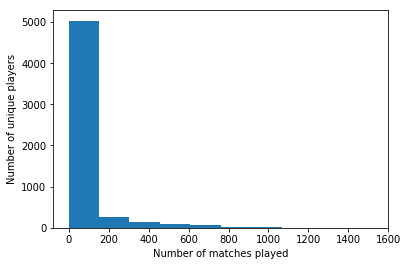

In [7]:
print(total[total < 150].shape)  
y, x = np.histogram(total)
plt.hist(total)
plt.ylabel('Number of unique players')
plt.xlabel('Number of matches played')
plt.show()

A vast majority of players has played less than 150 games, 5027 out of 5652 names.

Now I'd like to try to create an Elo-like scoring system. The most common elo scoring system is based upon the logistic  cumulative distribution function. 

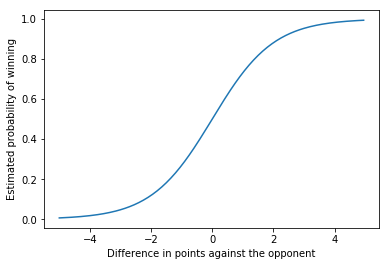

In [8]:
x = np.arange(-100,100)/20
y = 1/(1+np.exp(-x))
plt.plot(x, y)
plt.xlabel('Difference in points against the opponent')
plt.ylabel('Estimated probability of winning')
plt.show()

But nothing here tells us that the logistic distribution would work. 

Here we also have points for players, their ATP points specifically. This ranking is not exactly «fair» in the sense that some tournaments are worth more points than others, but we can still try to use it and see it's predictive value.

If we look at only the difference "winner"-"looser", we get to use a continuous variable, the score difference.

That variable can be used to predict what player will win. But it would work better if that variable was following a gaussian distribution.

In [9]:
scores = tennis_atp_records['winner_rank_points']-tennis_atp_records['loser_rank_points']
scores = scores[-scores.isnull()]

In [10]:
np.mean(scores)

329.22160337301733

In [11]:
scores.describe()

count    134479.000000
mean        329.221603
std        1357.318122
min      -15875.000000
25%           0.000000
50%           0.000000
75%         417.000000
max       16641.000000
dtype: float64

If we can find a distribution that fits the «scores difference» variable, then we can use that variable to predict the winner based solely on their ATP points. 

(array([8.0000e+00, 3.1000e+01, 9.7000e+01, 6.3900e+02, 9.8486e+04,
        3.1877e+04, 2.2560e+03, 6.6600e+02, 3.5200e+02, 6.7000e+01]),
 array([-15875. , -12623.4,  -9371.8,  -6120.2,  -2868.6,    383. ,
          3634.6,   6886.2,  10137.8,  13389.4,  16641. ]),
 <a list of 10 Patch objects>)

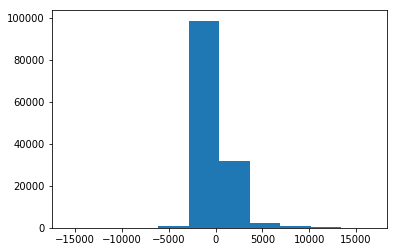

In [12]:
plt.hist(scores)

Although it looks like a gaussian or a logistic variable, it really is not.

In [13]:
counts, x_axis_values = np.histogram(scores, bins=1000)

In [14]:
frequency = counts/(len(scores)+1)

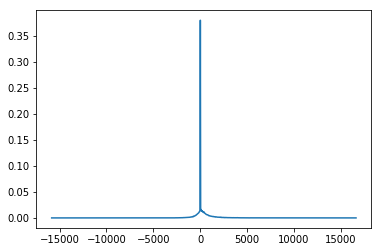

In [15]:
plt.plot(x_axis_values[1:], frequency)
from matplotlib.ticker import PercentFormatter


Apart from the very high number of 0 values, it could easily be a known distribution

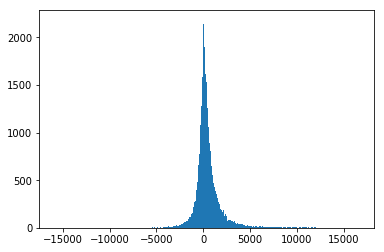

In [16]:

plt.hist(scores[scores!=0], bins=1000)
plt.show()


First I tried to test to see if it was any of the most famous distribution, but I couldn't find any that was satisfactory. So I decided to test on all the continuous variables of scipy, out of curiosity. I had to skip a few «too long to test» distributions, and sub-sample the data to be a little bit faster.

In [17]:
# dist_names = ['norm','lognorm','expon','pareto', 'cauchy', 'beta', 'alpha']
dist_names = ['norminvgauss', 't', 'tukeylambda']
testing_values = scores[scores!=0]
testing_values = np.random.choice(testing_values, size=1000)

# attempt to limit the time spent doing the kolmogorov-smirnov test, but it didn't work.
# use_signals is supposed to fix such issues with timeout_decorator, but didn't. Maybe it's due to the fact that
# the test is not computed with python code, but rather compiled C binaries
# @timeout_decorator.timeout(35, timeout_exception=StopIteration, use_signals=False) 
def get_kolmo(testing_values, dist_name, param):
    return scipy.stats.kstest(testing_values, dist_name, args=param)
#
all_time = {}
previous_dist = ""
for dist_name in dir(scipy.stats):
    if dist_name.startswith('_'):
        continue
    dist = getattr(scipy.stats, dist_name)
    if not isinstance(dist, rv_continuous):
        continue
    if previous_dist == 'levy_l':
        previous_dist = 'next'
        continue

    param = dist.fit(testing_values)
    #Applying the Kolmogorov-Smirnov test
    try:
        D, p = get_kolmo(testing_values, dist_name, param)
    except StopIteration:
        print("{} dist took too long, skipping".format(dist_name))
        continue
    all_time[dist_name] = p
    if p > 0.05:  
        print(p, dist_name)
    previous_dist = dist_name

/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide

/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1517: RuntimeWarning: overflow encountered in exp
  f = 1 + np.log(b) + sc.xlogy(b - 1.0, x) + xb - np.exp(xb)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1469: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1680: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For th

0.8788352471356645 johnsonsu


/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:82: RuntimeWarning: floating point number truncated to an integer
  return scu._smirnovc(n, x)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4290: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1618: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return integrate.quad(self._mom_integ1, 0, 1, ar

0.79565479043318 nct


/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1628: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, self.a, x, args=args)[0]
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1628: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._pdf, self.a, x, args=args)[0]
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: overflow encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: divide by zero encountered

Johnson-su seems to fit the data nicely, if we remove the cases where the rankings of the two players are equal.

In [18]:
coefs = scipy.stats.johnsonsu.fit(scores[scores!=0])
sub_scores = np.random.choice(scores[scores!=0], size=1000)
coefs_on_subset = scipy.stats.johnsonsu.fit(sub_scores)

Text(0.5, 1.0, 'QQ plot on just 1000 points')

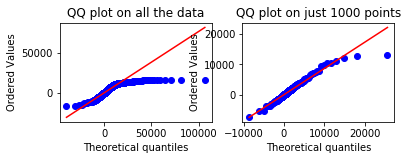

In [19]:
plt.subplot(221)
res = scipy.stats.probplot(scores[scores!=0], dist=scipy.stats.johnsonsu(*coefs),  plot=plt)
plt.title('QQ plot on all the data')
plt.subplot(222)

res = scipy.stats.probplot(sub_scores, dist=scipy.stats.johnsonsu(*coefs_on_subset),  plot=plt)
plt.title('QQ plot on just 1000 points')

By plotting the QQ plot, we can see that the Johnson-SU distribution doesn't work if we consider the whole dataset. 

In [20]:
df = pandas.DataFrame({"score_difference": scores, "win": 1})
total = pandas.concat([df, pandas.DataFrame({"score_difference": -scores, "win": 0})])

In [21]:
def prob_piecewise(input_data_var, output_result, n_bin=20):
    score_values = input_data_var
    largeness = np.max(score_values)-np.min(score_values)
    data_var_splited_min = np.arange(np.min(score_values), np.max(score_values), largeness/n_bin)
    data_var_splited_max = np.arange(np.min(score_values)+largeness/n_bin, np.max(score_values)+largeness/n_bin, largeness/n_bin)
    probs_piecewise = []
    for lower_bound, upper_bound in zip(data_var_splited_min, data_var_splited_max):
        mask = (lower_bound <= score_values) & (score_values < upper_bound)
        probs_piecewise.append(np.mean(output_result[mask]))
    return probs_piecewise, (data_var_splited_max+data_var_splited_min)/2

In [61]:
prob, x = prob_piecewise(total['score_difference'], total['win'], n_bin=50)


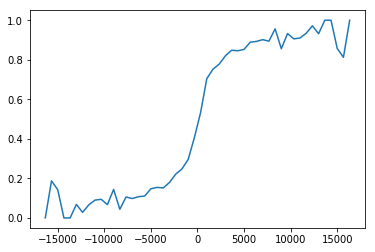

In [62]:
plt.plot(x,prob)

It's now time to see properly how a model trained on a fraction of the data would perform. And besides the ATP ranking, lets compute some ratios, that we will update on each game. I've though of two important ratios in tennis, the percentage of service ball that are first balls, because first balls are harder to return, and the percentage of break points saved, because a break point is usually a turning point where pundits say all is played. Besides, those points are probably played a bit differently than others, due to the high stakes, so it makes sense to observe this specific ratio. I'm sure we could build others, but for now, 3 variables will allow us to build a model easier to interpret.

On each game we will have 2 players, so as before, we'll take the difference between the 2 and use that as a variable.

First, some code to compute those ratios and add them to the main object

In [3]:
def get_new_ratio(
    one_line,
    ratio_per_player_previous_game, 
    ratio_per_player,
    exponential_parameter,
    numerator_column,
    denominator_column,
    player_name,
):
    try:
        ratio_on_this_game = one_line[numerator_column]/one_line[denominator_column]
    except ZeroDivisionError:
        ratio_on_this_game = np.nan

    if np.isnan(ratio_per_player.get(player_name, np.nan)):
        new_ratio = ratio_per_player_previous_game.get(player_name, np.nan)
    else:
        if np.isnan(ratio_per_player_previous_game.get(player_name, np.nan)):
            new_ratio = ratio_per_player.get(player_name, 0)
        else:
            new_ratio = (ratio_per_player.get(player_name, 0)*exponential_parameter +
                        ratio_per_player_previous_game.get(player_name, np.nan)*(1-exponential_parameter) 
                     ) 
    return new_ratio, ratio_on_this_game


def get_additional_variables(data_frame):
    input_data_frame = data_frame.copy()
    input_data_frame['w_first_ball_ratio'] = np.nan
    input_data_frame['l_first_ball_ratio'] = np.nan

    input_data_frame['w_bp_saved_ratio'] = np.nan
    input_data_frame['l_bp_saved_ratio'] = np.nan
    exponential_parameter = 0.8
    first_ball_in_ratio_per_player = {} # 1st_in/svpt
    break_points_saved_ratio_per_player = {} # bp_saved/ bp_Faced
    first_ball_in_ratio_per_player_previous_game = {} # 1st_in/svpt
    break_points_saved_ratio_per_player_previous_game = {} # bp_saved/ bp_Faced
    
    for _index, one_line in input_data_frame.iterrows():
        win = one_line['winner_name']
        los = one_line['loser_name']
        # set winner/looser first ball ratio and break point saved ratio
        
        for player_name, num_column, denom_culum, updating_column, ratio_per_player, ratio_per_player_previous_game in [
            (win, 'w_1stIn', 'w_svpt', 'w_first_ball_ratio', first_ball_in_ratio_per_player, first_ball_in_ratio_per_player_previous_game),
            (los, 'l_1stIn', 'l_svpt', 'l_first_ball_ratio', first_ball_in_ratio_per_player, first_ball_in_ratio_per_player_previous_game),
            (win, 'w_bpSaved', 'w_bpFaced', 'w_bp_saved_ratio', break_points_saved_ratio_per_player, break_points_saved_ratio_per_player_previous_game),
            (los, 'l_bpSaved', 'l_bpFaced', 'l_bp_saved_ratio', break_points_saved_ratio_per_player, break_points_saved_ratio_per_player_previous_game),

        ]:
            new_ratio, ratio_on_this_game = get_new_ratio(
                one_line, 
                ratio_per_player_previous_game,
                ratio_per_player,
                exponential_parameter=exponential_parameter,
                numerator_column=num_column,
                denominator_column=denom_culum,
                player_name=player_name
            )
            ratio_per_player[player_name] = new_ratio
            ratio_per_player_previous_game[player_name] = ratio_on_this_game
            input_data_frame.loc[_index, updating_column] = new_ratio
          
    return input_data_frame


Notice that we need to store the previous ratios of each player separetely, because when trying to predict the outcome of a game, we cannot use the percentage of first ball in of this game, as we don't have that information beforehand. We can thus only use his previous average (exponential average) and his current atp ranking, which is known beforehand.

In [4]:
# this may be slow, as expected. about 10 min. We are looping through 160k games, in python, and doing some non-negligible work on each step
tennis_atp_records_enhanced = get_additional_variables(tennis_atp_records)



/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 1.000e+01,
        2.700e+01, 3.100e+01, 5.900e+01, 1.030e+02, 1.690e+02, 2.850e+02,
        4.940e+02, 8.600e+02, 1.300e+03, 1.904e+03, 2.857e+03, 3.944e+03,
        5.204e+03, 6.390e+03, 7.382e+03, 7.972e+03, 8.304e+03, 7.857e+03,
        6.757e+03, 5.619e+03, 4.359e+03, 3.094e+03, 2.184e+03, 1.294e+03,
        8.730e+02, 5.520e+02, 3.160e+02, 1.850e+02, 1.090e+02, 8.800e+01,
        3.600e+01, 1.800e+01, 1.200e+01, 4.000e+00, 6.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00]),
 array([-5.16114912e-01, -4.97692511e-01, -4.79270110e-01, -4.60847709e-01,
        -4.42425308e-01, -4.24002907e-01, -4.05580506e-01, -3.87158105e-01,
        -3.68735704e-01, -3.50313303e-01, -3.31890902e-01, -3.13468501e-01,
        -2.95046100e-01, -2.76623700e-01, -2.58201299e-01, -2.39778898e-01,
        -2.21356497e-01, -2.02934096e-01, -1.84511695e-01, -1.66089294e-

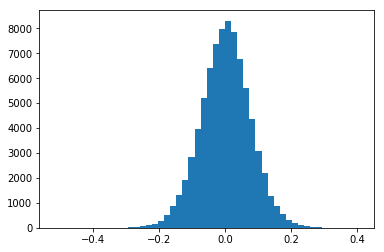

In [44]:
plt.hist(tennis_atp_records_enhanced['w_first_ball_ratio']-tennis_atp_records_enhanced['l_first_ball_ratio'], bins=50)

The distribution of the difference ratio for winners seems to be slighlty skewed towards the positive,  but overall the predictive value of that variable won't be a game changer

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 7.000e+00, 1.000e+01,
        1.600e+01, 2.700e+01, 4.000e+01, 8.000e+01, 1.560e+02, 2.810e+02,
        5.430e+02, 9.460e+02, 1.647e+03, 2.912e+03, 4.373e+03, 6.040e+03,
        7.950e+03, 9.261e+03, 9.662e+03, 9.753e+03, 8.132e+03, 6.403e+03,
        4.790e+03, 3.210e+03, 1.965e+03, 1.051e+03, 6.160e+02, 3.160e+02,
        1.560e+02, 9.200e+01, 5.600e+01, 4.500e+01, 3.900e+01, 2.400e+01,
        8.000e+00, 1.000e+01, 5.000e+00, 5.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.   , -0.962, -0.924, -0.886, -0.848, -0.81 , -0.772, -0.734,
        -0.696, -0.658, -0.62 , -0.582, -0.544, -0.506, -0.468, -0.43 ,
        -0.392, -0.354, -0.316, -0.278, -0.24 , -0.202, -0.164, -0.126,
        -0.088, -0.05 , -0.012,  0.026,  0.064,  0.102,  0.14 ,  0.178,
         0.216,  0.254,  0.292,  0.33 ,  0.368,  0.406,  0.444,  0.482,
         0.52 , 

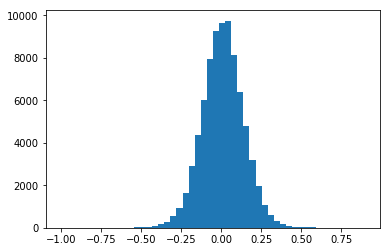

In [45]:
plt.hist(tennis_atp_records_enhanced['w_bp_saved_ratio']-tennis_atp_records_enhanced['l_bp_saved_ratio'], bins=50)

Same for the break points ratio.

In [47]:
def get_digestible_data(input_data):
    scores = input_data['winner_rank_points']-input_data['loser_rank_points']
    first_ball = input_data['w_first_ball_ratio']-input_data['l_first_ball_ratio']
    break_points_ratio = input_data['w_bp_saved_ratio']-input_data['l_bp_saved_ratio']
    df = pandas.DataFrame({"score_difference": scores, "first_in": first_ball, "bp_saved": break_points_ratio, "win": 1})
    total = pandas.concat([df, pandas.DataFrame({"score_difference": -scores, "first_in": -first_ball, "bp_saved": -break_points_ratio, "win": 0})])
    return total[['score_difference', 'first_in', 'bp_saved']], total['win']

In [63]:
train_fraction = 0.8
train_index_max = int(tennis_atp_records_enhanced.shape[0]*train_fraction)
tennis_data_nan_removed = tennis_atp_records_enhanced.fillna(tennis_atp_records_enhanced.mean())
train_data, test_data = tennis_data_nan_removed[:train_index_max], tennis_data_nan_removed[train_index_max:]
var_train, result_train = get_digestible_data(train_data)
var_test, result_test = get_digestible_data(test_data)

In [64]:
logit_model=sm.Logit(result_train, var_train)
result=logit_model.fit()
print(result.summary())

logistic_model = LogisticRegression()
logistic_model.fit(var_train, result_train)


Optimization terminated successfully.
         Current function value: 0.648463
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:               262344
Model:                          Logit   Df Residuals:                   262341
Method:                           MLE   Df Model:                            2
Date:                Tue, 26 Mar 2019   Pseudo R-squ.:                 0.06447
Time:                        09:43:09   Log-Likelihood:            -1.7012e+05
converged:                       True   LL-Null:                   -1.8184e+05
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
score_difference     0.0010   8.53e-06    116.041      0.000       0.001       0.001
first_in   

/home/francois/CasinoRoyal/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AttributeError: 'LogisticRegression' object has no attribute 'summary'

All three variables have a small enough p-value to be considered true predictors ( the likelyhood that the result is due to chance is small enough to be negligible, hence we can assume they are correct predictors )

In [65]:
logistic_model.score(var_test, result_test)

0.6671240813588266

The overall score might seem disappointing, but most of the data is composed of games where the odds are relatively on par for each player, especially players with 0 ATP points.

In [68]:
logistic_model.predict_proba(var_test)

array([[0.60180327, 0.39819673],
       [0.03881816, 0.96118184],
       [0.00118608, 0.99881392],
       ...,
       [0.77960503, 0.22039497],
       [0.79904631, 0.20095369],
       [0.78838926, 0.21161074]])

Given more time, I would first implement an elo score, as it has a better predictive value than the ATP ranking.

If I were allowed to gather more data, I would scrap online data to see what were the quotes on previous games, and back test the model against real gambling data.